In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet18_sp"

dataset_name="tsrd"

#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


Model: ResNet18_sp with 58 classes running on: tsrd


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '6': 54, '7': 55, '8': 56, '9': 57}
Dataset size: Train: 4000, Valid: 998, Test: 1000
torch.Size([3, 224, 224])
Datasets loaded and prepared


In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

        
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x=self.stn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
 
        return x

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model
 
 
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model
 
 
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model
 
 
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model
 
 
def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [5]:
model = resnet18()
model.fc=nn.Linear(512,num_classes)
model = model.to(device)

#pretesting model for shape
x=torch.randn(64,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

torch.Size([64, 3, 224, 224])
torch.Size([64, 58])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 218, 218]           1,184
         MaxPool2d-2          [-1, 8, 109, 109]               0
              ReLU-3          [-1, 8, 109, 109]               0
            Conv2d-4         [-1, 10, 105, 105]           2,010
         MaxPool2d-5           [-1, 10, 52, 52]               0
              ReLU-6           [-1, 10, 52, 52]               0
            Linear-7                   [-1, 32]         865,312
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10         [-1, 64, 112, 112]           9,408
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
        MaxPool2d-13           [-1

In [6]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [7]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet18_sp20211030195455
grandstore_string
grandstore/tsrd_ResNet18_sp20211030195455.pkl


In [8]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [9]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=120,
                    minepoch=30,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 29.459
Training Loss: 1185596.3043 	Validation Loss: 2538.5100

Running epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 40.982
Training Loss: 858518.3726 	Validation Loss: 1823.5183

Running epoch: 3


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 53.707
Training Loss: 691695.9737 	Validation Loss: 1464.4695

Running epoch: 4


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 55.812
Training Loss: 508555.2789 	Validation Loss: 1380.8297

Running epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 70.842
Training Loss: 364519.4091 	Validation Loss: 922.4030

Running epoch: 6


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 77.455
Training Loss: 263805.7944 	Validation Loss: 731.5420

Running epoch: 7


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 81.864
Training Loss: 198807.0497 	Validation Loss: 610.5086

Running epoch: 8


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.768
Training Loss: 139130.1675 	Validation Loss: 539.6570

Running epoch: 9


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.471
Training Loss: 118542.2576 	Validation Loss: 480.5442

Running epoch: 10


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 88.978
Training Loss: 95399.9914 	Validation Loss: 382.2286

Running epoch: 11


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 93.287
Training Loss: 78544.9179 	Validation Loss: 220.4316

Running epoch: 12


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 93.086
Training Loss: 33397.3297 	Validation Loss: 221.6522

Running epoch: 13


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 94.289
Training Loss: 22590.9424 	Validation Loss: 215.5391

Running epoch: 14


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.675
Training Loss: 76499.1567 	Validation Loss: 395.6674

Running epoch: 15


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 96.393
Training Loss: 35843.0571 	Validation Loss: 144.1068

Running epoch: 16


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 95.691
Training Loss: 22687.9844 	Validation Loss: 157.8065

Running epoch: 17


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 93.988
Training Loss: 24137.7162 	Validation Loss: 219.2901

Running epoch: 18


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 91.283
Training Loss: 20832.7815 	Validation Loss: 415.0632

Running epoch: 19


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 97.094
Training Loss: 23266.6724 	Validation Loss: 111.7863

Running epoch: 20


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 96.192
Training Loss: 15620.1256 	Validation Loss: 135.0146

Running epoch: 21


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.096
Training Loss: 11001.9924 	Validation Loss: 94.1648

Running epoch: 22


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 95.491
Training Loss: 16078.1158 	Validation Loss: 145.6194

Running epoch: 23


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 96.393
Training Loss: 45927.2383 	Validation Loss: 111.9888

Running epoch: 24


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 95.892
Training Loss: 32711.4547 	Validation Loss: 156.1036

Running epoch: 25


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 97.595
Training Loss: 23516.8753 	Validation Loss: 84.3619

Running epoch: 26


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.196
Training Loss: 5216.7552 	Validation Loss: 73.0377

Running epoch: 27


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.397
Training Loss: 2766.0172 	Validation Loss: 62.4735

Running epoch: 28


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.297
Training Loss: 2470.5058 	Validation Loss: 66.1403

Running epoch: 29


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.697
Training Loss: 2490.9005 	Validation Loss: 49.8520

Running epoch: 30


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.196
Training Loss: 2593.1389 	Validation Loss: 64.5409

Running epoch: 31


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 87.675
Training Loss: 26617.1212 	Validation Loss: 519.8812

Running epoch: 32


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 96.894
Training Loss: 52811.7616 	Validation Loss: 102.3896

Running epoch: 33


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 5922.9830 	Validation Loss: 38.5602

Running epoch: 34


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 3810.2336 	Validation Loss: 32.6279

Running epoch: 35


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.996
Training Loss: 8553.5733 	Validation Loss: 82.1556

Running epoch: 36


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.695
Training Loss: 16435.4520 	Validation Loss: 99.3533

Running epoch: 37


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.595
Training Loss: 8417.8314 	Validation Loss: 97.8531

Running epoch: 38


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 19902.3618 	Validation Loss: 34.4370

Running epoch: 39


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 5236.3409 	Validation Loss: 34.0365

Running epoch: 40


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 4241.0580 	Validation Loss: 33.7927

Running epoch: 41


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 1115.1354 	Validation Loss: 28.0002

Running epoch: 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1242.1643 	Validation Loss: 27.9228

Running epoch: 43


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 926.8305 	Validation Loss: 31.0648

Running epoch: 44


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 623.5999 	Validation Loss: 27.0404

Running epoch: 45


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1094.2164 	Validation Loss: 31.5145

Running epoch: 46


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 380.2555 	Validation Loss: 31.9815

Running epoch: 47


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 919.7370 	Validation Loss: 27.0756

Running epoch: 48


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 950.4242 	Validation Loss: 27.5203

Running epoch: 49


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.800
Training Loss: 897.7276 	Validation Loss: 21.3751

Running epoch: 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1069.5491 	Validation Loss: 22.9206

Running epoch: 51


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 876.5925 	Validation Loss: 26.6899

Running epoch: 52


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 249.5048 	Validation Loss: 26.1983

Running epoch: 53


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 603.0774 	Validation Loss: 28.6833

Running epoch: 54


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.800
Training Loss: 359.5848 	Validation Loss: 24.5115

Running epoch: 55


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.800
Training Loss: 719.5580 	Validation Loss: 25.7396

Running epoch: 56


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 435.3672 	Validation Loss: 25.6033

Running epoch: 57


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 230.2620 	Validation Loss: 24.4758

Running epoch: 58


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.800
Training Loss: 435.3264 	Validation Loss: 23.4501

Running epoch: 59


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 96.994
Training Loss: 67475.5491 	Validation Loss: 106.3354

Running epoch: 60


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.497
Training Loss: 21897.2675 	Validation Loss: 57.6922

Running epoch: 61


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 13416.4635 	Validation Loss: 21.6549

Running epoch: 62


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 3524.4777 	Validation Loss: 24.1709

Running epoch: 63


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1039.5762 	Validation Loss: 21.9553

Running epoch: 64


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 801.8978 	Validation Loss: 18.9379

Running epoch: 65


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 810.1801 	Validation Loss: 23.5301

Running epoch: 66


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 591.0109 	Validation Loss: 21.6171

Running epoch: 67


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 579.7446 	Validation Loss: 27.1313

Running epoch: 68


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 503.5981 	Validation Loss: 21.8892

Running epoch: 69


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 393.5822 	Validation Loss: 25.8130

Running epoch: 70


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 831.9769 	Validation Loss: 22.6539

Running epoch: 71


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 546.6134 	Validation Loss: 20.6359

early stop occured!!


  0%|          | 0/1000 [00:00<?, ?it/s]

Model of: ResNet18_sp running on: cifar10

Total Run 120 epoch(s)
Accuracy MIN: 56.68 / MAX: 85.44

Top 5 performing epochs:
#1 epoch 95	||train_acc 85.44%	||test 85.53%
#2 epoch 103	||train_acc 85.43%	||test 85.22%
#3 epoch 78	||train_acc 85.4%	||test 85.08%
#4 epoch 83	||train_acc 85.39%	||test 84.72%
#5 epoch 101	||train_acc 85.29%	||test 85.53%

Last epoch:
epoch 120	||train_acc 84.98%	||test 84.2%

The model has parameters: 12050346


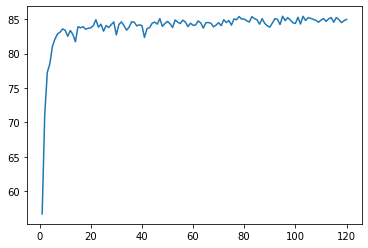

In [9]:
print("Model of: "+model_name +
      " running on: "+dataset_name+"\n")

print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)